# Iteration 2

## Targets:
- Add BatchNormalization
- Add transition layers
## Results: 
```
Total params: 334,934
Best results obtained in epoch: 14
Test accuracy: 99.52
Train accuracy: 100.0 
```
## Analysis:
- The order of convolution has helped achieve the target early on. I am using 3 conv-relu-BN blocks, followed by max pool + transition 1x1 conv and 4 conv blocks and finally another convolution to reduce the channels to 10
- But the number of parameters are huge, next target is to reduce this


In [12]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:

class ConvReluBatchNorm(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=(3,3), dropout=0.0, padding=0, **kwargs):
    super(ConvReluBatchNorm, self).__init__()
    self.convblock = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, **kwargs),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    return self.convblock(x)

In [4]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = ConvReluBatchNorm(in_channels=1, out_channels=32) # in = 28 , out = 26, RF = 3
        self.conv2 = ConvReluBatchNorm(in_channels=32, out_channels=48)# in = 26 , out = 24, RF = 5
        self.conv3 = ConvReluBatchNorm(in_channels=48, out_channels=64) # in = 24 , out = 22, RF = 7
        self.pool1 = nn.MaxPool2d(2, 2) # in = 22 , out = 11, RF = 14
        # 1x1 to reduce channels
        self.transition_1 = ConvReluBatchNorm(in_channels=64, out_channels=16, kernel_size=(1,1)) # in = 11 , out = 9, RF = 16
        # normal 3x3 to increase channels
        self.conv4 = ConvReluBatchNorm(in_channels=16, out_channels=32) # in = 9 , out = 7, RF = 18
        self.conv5 = ConvReluBatchNorm(in_channels=32, out_channels=64) # in = 7 , out = 5, RF = 20
        self.conv6 = ConvReluBatchNorm(in_channels=64, out_channels=128) # in = 5 , out = 3, RF = 16
        self.conv7 = ConvReluBatchNorm(in_channels=128, out_channels=156) # in = 5 , out = 3, RF = 16
        self.conv8 = nn.Conv2d(in_channels=156, out_channels=10, kernel_size=(3, 3), padding=0) # in = 3 , out = 1, RF = 16

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.transition_1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [5]:
# in = 22 , out = 11, RF = 14!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
       BatchNorm2d-3           [-1, 32, 26, 26]              64
           Dropout-4           [-1, 32, 26, 26]               0
 ConvReluBatchNorm-5           [-1, 32, 26, 26]               0
            Conv2d-6           [-1, 48, 24, 24]          13,872
              ReLU-7           [-1, 48, 24, 24]               0
       BatchNorm2d-8           [-1, 48, 24, 24]              96
           Dropout-9           [-1, 48, 24, 24]               0
ConvReluBatchNorm-10           [-1, 48, 24, 24]               0
           Conv2d-11           [-1, 64, 22, 22]          27,712
             ReLU-12           [-1, 64, 22, 22]               0
      BatchNorm2d-13           [-1, 64, 22, 22]             128
          Dropout-14           [-1, 64,

In [6]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


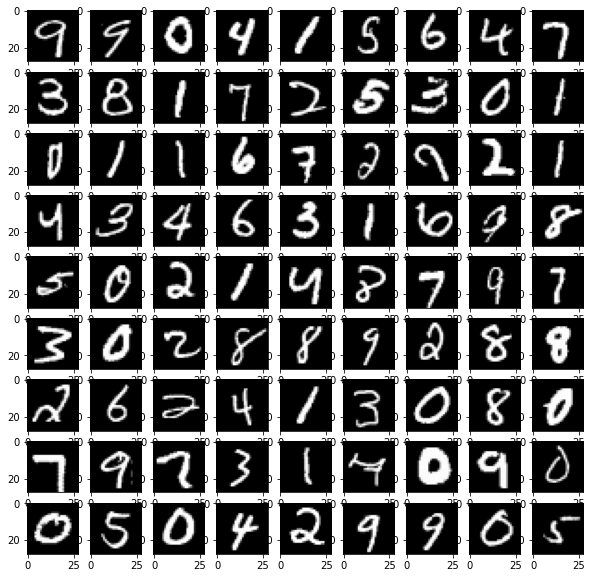

In [7]:
# Display training images
plt.figure(figsize=(10,10))
for i in range(9*9):
    plt.subplot(9,9,i+1)   
    imgs, lbls = next(iter(train_loader))
    plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray") 
    # plt.imshow(img[i,:,:16])

plt.show()

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_acc_epoch = []
train_loss_epoch = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    if batch_idx == 468:
      train_acc_epoch.append(100*correct/processed)
      train_loss_epoch.append(loss.item())    

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
acc_thresh = 99.94
EPOCHS = 15

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    if test_acc[-1] >= acc_thresh:
      print(f"HURRAY, You did it !!!!")

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.04286385700106621 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9886/10000 (98.86%)

EPOCH: 1


Loss=0.1480615884065628 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:26<00:00, 17.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9922/10000 (99.22%)

EPOCH: 2


Loss=0.010065600275993347 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9907/10000 (99.07%)

EPOCH: 3


Loss=0.0008473559864796698 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.006889063864946365 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:26<00:00, 17.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 5


Loss=0.02952594868838787 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.0034771289210766554 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.00034497803426347673 Batch_id=468 Accuracy=99.98: 100%|██████████| 469/469 [00:26<00:00, 17.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9949/10000 (99.49%)

EPOCH: 8


Loss=0.00022372677631210536 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 9


Loss=0.0013799614971503615 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=5.2894876716891304e-05 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9948/10000 (99.48%)

EPOCH: 11


Loss=0.00036304653622210026 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9950/10000 (99.50%)

EPOCH: 12


Loss=5.7328015827806666e-05 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:27<00:00, 17.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9949/10000 (99.49%)

EPOCH: 13


Loss=0.0002606587659101933 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:27<00:00, 17.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9951/10000 (99.51%)

EPOCH: 14


Loss=0.0002641427854541689 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]



Test set: Average loss: 0.0184, Accuracy: 9952/10000 (99.52%)



In [10]:
best_epoch = np.argmax(test_acc)
print(f"Best results obtained in epoch: {best_epoch}")
print(f'Test accuracy: {test_acc[best_epoch]}\nTrain accuracy: {train_acc_epoch[best_epoch]}')

Best results obtained in epoch: 14
Test accuracy: 99.52
Train accuracy: 100.0


Text(0.5, 1.0, 'Test Accuracy')

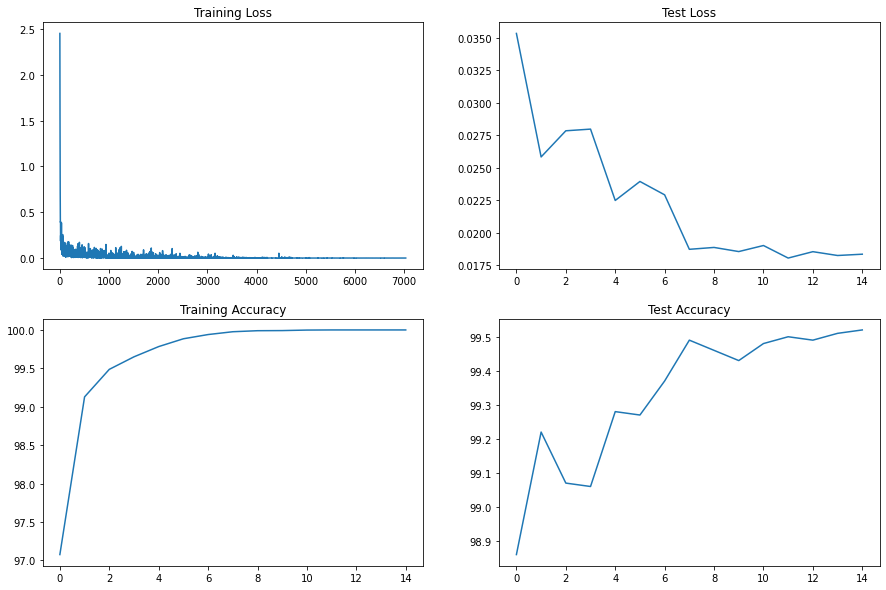

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_epoch)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")